In [1]:
import sys
import os

sys.path.append("../")
# ! pip install -r ../../../requirements.txt
import config
# ! pip install --upgrade numexpr
import numpy as np
import matplotlib.pyplot as plt
from smartprint import smartprint as sprint
from preprocessing.ProcessRaw import ProcessRaw
import pandas as pd

In [2]:
city_color = {"london" : "#E69F00", 
             "melbourne": "#0072B2",
             "madrid": "#CC79A7"}

In [3]:
import pandas as pd
df_cx = pd.read_csv("adam_001_30_epochs/IC_file.csv")
df_cx.head()

,cityname,i_o_length,prediction_horizon,grid_size,cx_sample_whole_data,CSR_MP_sum_y_exceeding_r_x_max,CSR_PM_sum_y_exceeding_r_x_max,CSR_NM_sum_y_exceeding_r_x_max,CSR_GB_sum_y_exceeding_r_x_max,CSR_PM_std,CSR_MP_std,CSR_MP_count,CSR_PM_count,CSR_NM_count,CSR_GB_count
0,madrid,1,1,55,1000,-1,2244.621153,0,9999,5383.514251,-1,-1,1000,-1,-1
1,madrid,2,1,55,1000,-1,2710.185000,0,9999,5935.583166,-1,-1,1000,-1,-1
2,madrid,3,1,55,1000,-1,3862.898000,0,9999,8218.365227,-1,-1,1000,-1,-1
3,madrid,4,1,55,1000,-1,5267.594750,0,9999,9677.242777,-1,-1,1000,-1,-1
4,madrid,5,1,55,1000,-1,6897.292000,0,9999,14739.799876,-1,-1,1000,-1,-1


GIGO case:  madrid-4-1-45-
GIGO case:  madrid-4-1-25-


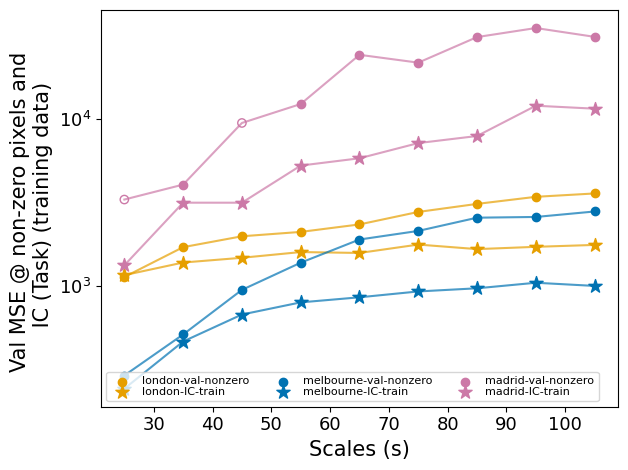

In [4]:
import pandas as pd


# scales
for city in config.city_list:

    cityname = city.lower()
    line_plot_Val_loss = []

    city_label_printed = []

    val_loss_non_zero_list = []
    csr_model_list = []
    csr_PM_list = []
    csr_PM_frac_list = []
    
    for scale in config.scales[::-1]: #list(range(25, 206, 30))[::-1] + 
        for i_o_length in config.i_o_lengths_def:
            for pred_horiz in config.pred_horiz_def:
                prefix = ProcessRaw.file_prefix(cityname=cityname,
                                                io_length=i_o_length, 
                                                pred_horiz=pred_horiz, 
                                                scale=scale)
                filename = "val_csv_" + prefix + ".csv"
                try:
                    df = pd.read_csv(os.path.join("val_csv_all_models_all_cities", filename))
                except (pd.errors.EmptyDataError, FileNotFoundError) as e:
                    print (cityname, " Empty/Not found, ignoring; plot will be missing")
                    print (e)
                    continue
                    
                epoch_list = df.epoch.tolist()
                val_loss = df.val_loss.tolist()
                naive_model= df["naive-model-non-zero"].tolist()
                val_non_zero_mse = df["val_non_zero_mse"].tolist()

                argmin = np.argmin(val_loss)

                min_val_mse_non_zero = val_non_zero_mse[argmin]

                alpha = 1
                facecolor = city_color[cityname]
                
                if naive_model[-1] < min_val_mse_non_zero:
                    # invalid, GIGO regime
                    print ("GIGO case: ", prefix)                    
                    
                    facecolor='none'
                    
                    # continue                    
                    
                if cityname in city_label_printed:
                    plt.scatter(scale, min_val_mse_non_zero, 
                                alpha=alpha,
                                facecolor=facecolor,
                                edgecolors=city_color[cityname])                 
                else:
                    plt.scatter(scale, min_val_mse_non_zero, 
                                alpha=alpha, 
                                label=cityname+ "-val-nonzero",
                                facecolor=facecolor,
                                edgecolors=city_color[cityname])
                    city_label_printed.append(cityname)
                line_plot_Val_loss.append(min_val_mse_non_zero)
                # plt.scatter(scale, naive_model[-1], marker='v', color=city_color[cityname])

    for CSR_type in [
    'CSR_PM_sum_y_exceeding_r_x_max',
        ]:

        cityname = city.lower()
        line_plot_IC = []


        city_label_printed = []      
        df = df_cx    

        # sprint (df.columns)
        for scale in config.scales[::-1]:
            for i_o_length in config.i_o_lengths_def:
                for pred_horiz in config.pred_horiz_def:

                    filtered_rows = df[    \
                                       (df["i_o_length"]==i_o_length) & \
                                       (df["grid_size"]==scale) & \
                                       (df["prediction_horizon"]==pred_horiz) &\
                                       (df["cityname"]==cityname)
                                      ]
                  
                            
                    if cityname in city_label_printed:
                        plt.scatter(scale,  filtered_rows.iloc[0][CSR_type], marker='*',color=city_color[cityname], alpha=1,
                                   s=100)
                    else:
                        plt.scatter(scale,  filtered_rows.iloc[0][CSR_type], marker='*',label=cityname + "-IC-train", alpha=1, color=city_color[cityname],
                                   s=100)
                        city_label_printed.append(cityname)   
                    
                    line_plot_IC.append(filtered_rows.iloc[0][CSR_type])
                            
    plt.plot(config.scales[::-1], line_plot_IC, color=city_color[cityname], alpha=0.7)
    plt.plot(config.scales[::-1], line_plot_Val_loss, color=city_color[cityname], alpha=0.7)
    
plt.xlabel(r"Scales (s)", fontsize=15)
plt.ylabel("Val MSE @ non-zero pixels and \n IC (Task) (training data)", fontsize=15)
plt.yscale('symlog')
# plt.ylim(bottom=0.101)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc="best", fontsize=8, ncol=3, labelspacing=0.02)
plt.tight_layout()
plt.savefig("Scales_csr_val_combo.png")
plt.show()





 np.arctan(p[0]) /2/3.141 * 360,   p[0]         : 81.39846269481532 6.599032083333324
The condition holds for i = 0, j = 1, k = 8 melbourne 244.043 467.3475 1004.618 ratio 1.0000000000000002
The condition holds for i = 0, j = 7, k = 1 melbourne 244.043 1049.406 467.3475 ratio 1.0000000000000002
The condition holds for i = 1, j = 0, k = 8 melbourne 467.3475 244.043 1004.618 ratio 1.0000000000000002
The condition holds for i = 1, j = 2, k = 7 melbourne 467.3475 677.60325 1049.406 ratio 1.0000000000000002
The condition holds for i = 1, j = 3, k = 7 melbourne 467.3475 801.03075 1049.406 ratio 1.0000000000000002
The condition holds for i = 1, j = 4, k = 7 melbourne 467.3475 858.987 1049.406 ratio 1.0000000000000002
The condition holds for i = 1, j = 5, k = 7 melbourne 467.3475 931.026 1049.406 ratio 1.0000000000000002
The condition holds for i = 1, j = 6, k = 7 melbourne 467.3475 972.424 1049.406 ratio 1.0000000000000002
The condition holds for i = 1, j = 8, k = 7 melbourne 467.3475 1004.61

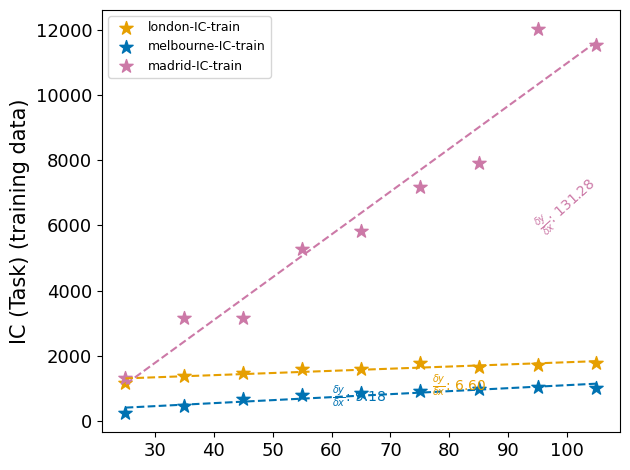

In [197]:
import pandas as pd


# scales
for city in config.city_list:

    cityname = city.lower()
    line_plot_Val_loss = []

    city_label_printed = []

    val_loss_non_zero_list = []
    csr_model_list = []
    csr_PM_list = []
    csr_PM_frac_list = []
    
    for scale in config.scales[::-1]: #list(range(25, 206, 30))[::-1] + 
        for i_o_length in config.i_o_lengths_def:
            for pred_horiz in config.pred_horiz_def:
                prefix = ProcessRaw.file_prefix(cityname=cityname,
                                                io_length=i_o_length, 
                                                pred_horiz=pred_horiz, 
                                                scale=scale)
                filename = "val_csv_" + prefix + ".csv"
                try:
                    df = pd.read_csv(os.path.join("val_csv_all_models_all_cities", filename))
                except (pd.errors.EmptyDataError, FileNotFoundError) as e:
                    print (cityname, " Empty/Not found, ignoring; plot will be missing")
                    print (e)
                    continue
                    
                epoch_list = df.epoch.tolist()
                val_loss = df.val_loss.tolist()
                naive_model= df["naive-model-non-zero"].tolist()
                val_non_zero_mse = df["val_non_zero_mse"].tolist()

                argmin = np.argmin(val_loss)

                min_val_mse_non_zero = val_non_zero_mse[argmin]

                alpha = 1
                facecolor = city_color[cityname]
                
                if naive_model[-1] < min_val_mse_non_zero:
                    # invalid, GIGO regime
                    print ("GIGO case: ", prefix)                    
                    
                    facecolor='none'
                    
                    # continue                    

    for CSR_type in [
    'CSR_PM_sum_y_exceeding_r_x_max',
        ]:

        cityname = city.lower()
        line_plot_IC = []


        city_label_printed = []      
        df = df_cx    

        # sprint (df.columns)
        for scale in config.scales[::-1]:
            for i_o_length in config.i_o_lengths_def:
                for pred_horiz in config.pred_horiz_def:

                    filtered_rows = df[    \
                                       (df["i_o_length"]==i_o_length) & \
                                       (df["grid_size"]==scale) & \
                                       (df["prediction_horizon"]==pred_horiz) &\
                                       (df["cityname"]==cityname)
                                      ]
                  
                            
                    if cityname in city_label_printed:
                        plt.scatter(scale,  filtered_rows.iloc[0][CSR_type], marker='*',color=city_color[cityname], alpha=1,
                                   s=100)
                    else:
                        plt.scatter(scale,  filtered_rows.iloc[0][CSR_type], marker='*',label=cityname + "-IC-train", alpha=1, color=city_color[cityname],
                                   s=100)
                        city_label_printed.append(cityname)   
                    
                    line_plot_IC.append(filtered_rows.iloc[0][CSR_type])
                            
    # plt.plot(config.scales[::-1], np.array(line_plot_IC), color=city_color[cityname], alpha=0.7)
    
    p = np.polyfit(config.scales[::-1], line_plot_IC, 1)  # p will contain [slope, intercept]
    line_y = np.polyval(p, config.scales[::-1])  # This evaluates the polynomial at each point in line_plot_IC
    plt.plot(config.scales[::-1], line_y, color=city_color[cityname], linestyle='--')

    # Calculate the position for text
    text_x = config.scales[::-1][0]//2 + int (np.random.rand()*50)  # Adjust these values to position the text appropriately
    text_y = line_y[0]  # Adjust these values to position the text appropriately

    rr = 0
    if cityname == "madrid":
        rr = 42
    text_y /= 2


    a = line_plot_IC[::-1]
    n = len(a)
    
    # Nested loops to check the condition for all possible combinations of i, j, and k
    for i in range(n):
        for j in range(n):
            for k in range(n):
                if i != j and i != k and j != k:  # Ensure i, j, and k are distinct
                    if (a[i] - a[j])/ ((a[k] - a[j]) + (a[i] - a[k])) > 1: #  and i>j and k>0 and j>0:
                        print(f"The condition holds for i = {i}, j = {j}, k = {k}", cityname, a[i], a[j], a[k],
                             "ratio",  (a[i] - a[j])/ ((a[k] - a[j]) + (a[i] - a[k]))) 


    # Display the slope value on the plot
    plt.text(
             text_x, 
             text_y, 
             r'$\frac{\delta y}{\delta x}$' + f': {p[0]:.2f}', 
             color=city_color[cityname], 
             fontsize=10, 
             rotation=rr,#np.arctan(p[0]) / (2*3.141) * 360 * 45 /(131-6)
            )

    sprint ( np.arctan(p[0]) /2/3.141 * 360,   p[0]        )
    # plt.plot(config.scales[::-1], line_plot_Val_loss, color=city_color[cityname], alpha=0.7)
    
plt.ylabel("IC (Task) (training data)", fontsize=15)
# plt.yscale('symlog')
# plt.ylim(bottom=0.101)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc="best", fontsize=9, ncol=1)
plt.tight_layout()
plt.savefig("Scale_increase_slope.png")
plt.show()

 np.arctan(p[0]) /2/3.141 * 360,   p[0]         : 89.78985317406669 252.30800892857147
GIGO case:  melbourne-1-1-55-
GIGO case:  melbourne-2-1-55-
 np.arctan(p[0]) /2/3.141 * 360,   p[0]         : 89.53528533970264 118.96553869047624
GIGO case:  madrid-1-1-55-
GIGO case:  madrid-7-1-55-
GIGO case:  madrid-8-1-55-
 np.arctan(p[0]) /2/3.141 * 360,   p[0]         : 89.97457873384998 1351.4828026875532


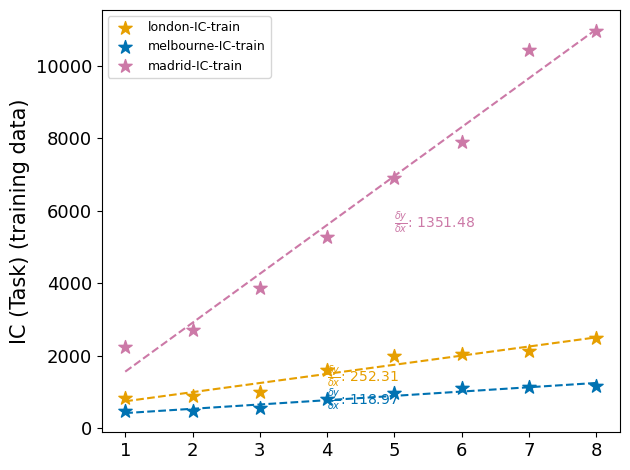

In [194]:
import pandas as pd


# scales
for city in config.city_list:

    cityname = city.lower()
    line_plot_Val_loss = []

    city_label_printed = []

    val_loss_non_zero_list = []
    csr_model_list = []
    csr_PM_list = []
    csr_PM_frac_list = []
    
    for scale in config.scales_def: #list(range(25, 206, 30))[::-1] + 
        for i_o_length in config.i_o_lengths:
            for pred_horiz in config.pred_horiz_def:
                prefix = ProcessRaw.file_prefix(cityname=cityname,
                                                io_length=i_o_length, 
                                                pred_horiz=pred_horiz, 
                                                scale=scale)
                filename = "val_csv_" + prefix + ".csv"
                try:
                    df = pd.read_csv(os.path.join("val_csv_all_models_all_cities", filename))
                except (pd.errors.EmptyDataError, FileNotFoundError) as e:
                    print (cityname, " Empty/Not found, ignoring; plot will be missing")
                    print (e)
                    continue
                    
                epoch_list = df.epoch.tolist()
                val_loss = df.val_loss.tolist()
                naive_model= df["naive-model-non-zero"].tolist()
                val_non_zero_mse = df["val_non_zero_mse"].tolist()

                argmin = np.argmin(val_loss)

                min_val_mse_non_zero = val_non_zero_mse[argmin]

                alpha = 1
                facecolor = city_color[cityname]
                
                if naive_model[-1] < min_val_mse_non_zero:
                    # invalid, GIGO regime
                    print ("GIGO case: ", prefix)                    
                    
                    facecolor='none'
                    
                    # continue                    

    for CSR_type in [
    'CSR_PM_sum_y_exceeding_r_x_max',
        ]:

        cityname = city.lower()
        line_plot_IC = []


        city_label_printed = []      
        df = df_cx    

        # sprint (df.columns)
        for scale in config.scales_def:
            for i_o_length in config.i_o_lengths:
                for pred_horiz in config.pred_horiz_def:

                    filtered_rows = df[    \
                                       (df["i_o_length"]==i_o_length) & \
                                       (df["grid_size"]==scale) & \
                                       (df["prediction_horizon"]==pred_horiz) &\
                                       (df["cityname"]==cityname)
                                      ]
                  
                            
                    if cityname in city_label_printed:
                        plt.scatter(i_o_length,  filtered_rows.iloc[0][CSR_type], marker='*',color=city_color[cityname], alpha=1,
                                   s=100)
                    else:
                        plt.scatter(i_o_length,  filtered_rows.iloc[0][CSR_type], marker='*',label=cityname + "-IC-train", alpha=1, color=city_color[cityname],
                                   s=100)
                        city_label_printed.append(cityname)   
                    
                    line_plot_IC.append(filtered_rows.iloc[0][CSR_type])
                            
    # plt.plot(config.scales[::-1], np.array(line_plot_IC), color=city_color[cityname], alpha=0.7)
    
    p = np.polyfit(config.i_o_lengths, line_plot_IC, 1)  # p will contain [slope, intercept]
    line_y = np.polyval(p, config.i_o_lengths)  # This evaluates the polynomial at each point in line_plot_IC
    plt.plot(config.i_o_lengths, line_y, color=city_color[cityname], linestyle='--')

    # Calculate the position for text
    text_x = config.i_o_lengths[-1]//2 + int (np.random.rand()*3)  # Adjust these values to position the text appropriately
    text_y = line_y[-1]//2  # Adjust these values to position the text appropriately

    rr = 0
    # if cityname == "madrid":
    #     rr = 42
    # text_y /= 2

    a = line_plot_IC
    n = len(a)
    
    # Nested loops to check the condition for all possible combinations of i, j, and k
    for i in range(n):
        for j in range(n):
            for k in range(n):
                if i != j and i != k and j != k:  # Ensure i, j, and k are distinct
                    if (a[i] - a[j])/ ((a[k] - a[j]) + (a[i] - a[k])) > 1: #  and i>j and k>0 and j>0:
                        print(f"The condition holds for i = {i}, j = {j}, k = {k}", cityname, a[i], a[k], a[j],
                             "ratio",  (a[i] - a[j])/ ((a[k] - a[j]) + (a[i] - a[k])))
    # Display the slope value on the plot
    plt.text(
             text_x, 
             text_y, 
             r'$\frac{\delta y}{\delta x}$' + f': {p[0]:.2f}', 
             color=city_color[cityname], 
             fontsize=10, 
             rotation=rr,#np.arctan(p[0]) / (2*3.141) * 360 * 45 /(131-6)
            )

    sprint ( np.arctan(p[0]) /2/3.141 * 360,   p[0]        )
    # plt.plot(config.scales[::-1], line_plot_Val_loss, color=city_color[cityname], alpha=0.7)
    
plt.ylabel("IC (Task) (training data)", fontsize=15)
# plt.yscale('symlog')
# plt.ylim(bottom=0.101)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc="best", fontsize=9, ncol=1)
plt.tight_layout()
plt.savefig("IO_increase_slope.png")
plt.show()

 np.arctan(p[0]) /2/3.141 * 360,   p[0]         : 89.59614244228571 136.169782738095
 np.arctan(p[0]) /2/3.141 * 360,   p[0]         : 89.01564027664409 57.224008928571436
 np.arctan(p[0]) /2/3.141 * 360,   p[0]         : 89.92731093623385 639.0788124999992


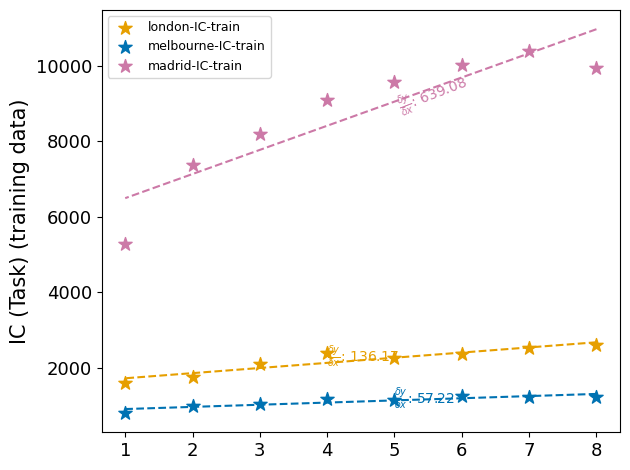

In [178]:
import pandas as pd


# scales
for city in config.city_list:

    cityname = city.lower()
    line_plot_Val_loss = []

    city_label_printed = []

    val_loss_non_zero_list = []
    csr_model_list = []
    csr_PM_list = []
    csr_PM_frac_list = []
    
    for scale in config.scales_def: #list(range(25, 206, 30))[::-1] + 
        for i_o_length in config.i_o_lengths_def:
            for pred_horiz in config.pred_horiz[::-1]:
                prefix = ProcessRaw.file_prefix(cityname=cityname,
                                                io_length=i_o_length, 
                                                pred_horiz=pred_horiz, 
                                                scale=scale)
                filename = "val_csv_" + prefix + ".csv"
                try:
                    df = pd.read_csv(os.path.join("val_csv_all_models_all_cities", filename))
                except (pd.errors.EmptyDataError, FileNotFoundError) as e:
                    print (cityname, " Empty/Not found, ignoring; plot will be missing")
                    print (e)
                    continue
                    
                epoch_list = df.epoch.tolist()
                val_loss = df.val_loss.tolist()
                naive_model= df["naive-model-non-zero"].tolist()
                val_non_zero_mse = df["val_non_zero_mse"].tolist()

                argmin = np.argmin(val_loss)

                min_val_mse_non_zero = val_non_zero_mse[argmin]

                alpha = 1
                facecolor = city_color[cityname]
                
                if naive_model[-1] < min_val_mse_non_zero:
                    # invalid, GIGO regime
                    print ("GIGO case: ", prefix)                    
                    
                    facecolor='none'
                    
                    # continue                    

    for CSR_type in [
    'CSR_PM_sum_y_exceeding_r_x_max',
        ]:

        cityname = city.lower()
        line_plot_IC = []


        city_label_printed = []      
        df = df_cx    

        # sprint (df.columns)
        for scale in config.scales_def:
            for i_o_length in config.i_o_lengths_def:
                for pred_horiz in config.pred_horiz[::-1]:

                    filtered_rows = df[    \
                                       (df["i_o_length"]==i_o_length) & \
                                       (df["grid_size"]==scale) & \
                                       (df["prediction_horizon"]==pred_horiz) &\
                                       (df["cityname"]==cityname)
                                      ]
                  
                            
                    if cityname in city_label_printed:
                        plt.scatter(pred_horiz,  filtered_rows.iloc[0][CSR_type], marker='*',color=city_color[cityname], alpha=1,
                                   s=100)
                    else:
                        plt.scatter(pred_horiz,  filtered_rows.iloc[0][CSR_type], marker='*',label=cityname + "-IC-train", alpha=1, color=city_color[cityname],
                                   s=100)
                        city_label_printed.append(cityname)   
                    
                    line_plot_IC.append(filtered_rows.iloc[0][CSR_type])
                            
    # plt.plot(config.scales[::-1], np.array(line_plot_IC), color=city_color[cityname], alpha=0.7)
    
    p = np.polyfit(config.pred_horiz[::-1], line_plot_IC, 1)  # p will contain [slope, intercept]
    line_y = np.polyval(p, config.pred_horiz[::-1])  # This evaluates the polynomial at each point in line_plot_IC
    plt.plot(config.pred_horiz[::-1], line_y, color=city_color[cityname], linestyle='--')

    # Calculate the position for text
    text_x = config.pred_horiz[::-1][0]//2 + int (np.random.rand()*3)  # Adjust these values to position the text appropriately
    text_y = line_y[0]* 1.6  # Adjust these values to position the text appropriately

    rr = 0
    if cityname == "madrid":
        rr = 21
    text_y /= 2

    a = line_y  # Replace with your list of values
    
    # Length of the list
    n = len(a)
    
    # Nested loops to check the condition for all possible combinations of i, j, and k
    for i in range(n):
        for j in range(n):
            for k in range(n):
                if i != j and i != k and j != k:  # Ensure i, j, and k are distinct
                    if a[i] - a[j] < (a[k] - a[j]) + (a[i] - a[k]):
                        print(f"The condition holds for i = {i}, j = {j}, k = {k}")

# Output will show the indices i, j, and k where the condition holds

    
    # Display the slope value on the plot
    plt.text(
             text_x, 
             text_y, 
             r'$\frac{\delta y}{\delta x}$' + f': {p[0]:.2f}', 
             color=city_color[cityname], 
             fontsize=10, 
             rotation=rr,#np.arctan(p[0]) / (2*3.141) * 360 * 45 /(131-6)
            )

    sprint ( np.arctan(p[0]) /2/3.141 * 360,   p[0]        )
    # plt.plot(config.scales[::-1], line_plot_Val_loss, color=city_color[cityname], alpha=0.7)
    
plt.ylabel("IC (Task) (training data)", fontsize=15)
# plt.yscale('symlog')
# plt.ylim(bottom=0.101)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc="best", fontsize=9, ncol=1)
plt.tight_layout()
plt.savefig("PH_increase_slope.png")
plt.show()

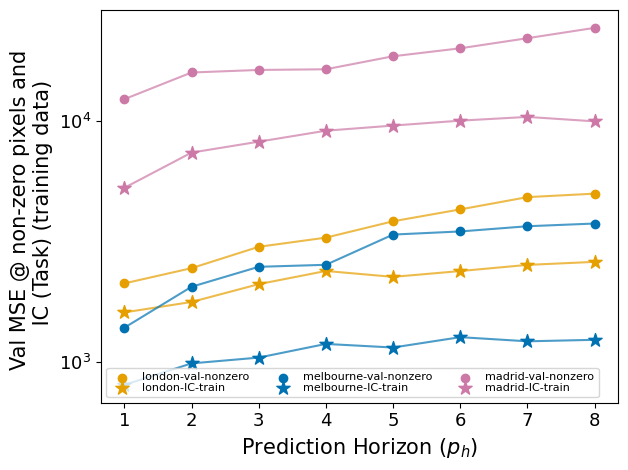

In [6]:
import pandas as pd


# scales
for city in config.city_list:

    cityname = city.lower()
    line_plot_Val_loss = []

    city_label_printed = []

    val_loss_non_zero_list = []
    csr_model_list = []
    csr_PM_list = []
    csr_PM_frac_list = []
    
    for scale in config.scales_def: #list(range(25, 206, 30))[::-1] + 
        for i_o_length in config.i_o_lengths_def:
            for pred_horiz in config.pred_horiz:
                prefix = ProcessRaw.file_prefix(cityname=cityname,
                                                io_length=i_o_length, 
                                                pred_horiz=pred_horiz, 
                                                scale=scale)
                filename = "val_csv_" + prefix + ".csv"
                try:
                    df = pd.read_csv(os.path.join("val_csv_all_models_all_cities", filename))
                except (pd.errors.EmptyDataError, FileNotFoundError) as e:
                    print (cityname, " Empty/Not found, ignoring; plot will be missing")
                    print (e)
                    continue
                    
                    
                epoch_list = df.epoch.tolist()
                val_loss = df.val_loss.tolist()
                naive_model= df["naive-model-non-zero"].tolist()
                val_non_zero_mse = df["val_non_zero_mse"].tolist()

                argmin = np.argmin(val_loss)

                min_val_mse_non_zero = val_non_zero_mse[argmin]

                alpha = 1
                facecolor = city_color[cityname]
                
                if naive_model[-1] < min_val_mse_non_zero:
                    # invalid, GIGO regime
                    print ("GIGO case: ", prefix)                    
                    
                    facecolor='none'
                    
                    # continue                    
                    
                if cityname in city_label_printed:
                    plt.scatter(pred_horiz, min_val_mse_non_zero, 
                                alpha=alpha,
                                facecolor=facecolor,
                                edgecolors=city_color[cityname])                 
                else:
                    plt.scatter(pred_horiz, min_val_mse_non_zero, 
                                alpha=alpha, 
                                label=cityname+ "-val-nonzero",
                                facecolor=facecolor,
                                edgecolors=city_color[cityname])
                    city_label_printed.append(cityname)
                line_plot_Val_loss.append(min_val_mse_non_zero)
                # plt.scatter(pred_horiz, naive_model[-1], marker='v', color=city_color[cityname])

    for CSR_type in [
    'CSR_PM_sum_y_exceeding_r_x_max',
        ]:

        cityname = city.lower()
        line_plot_IC = []


        city_label_printed = []      
        df = df_cx    

        # sprint (df.columns)
        for scale in config.scales_def:
            for i_o_length in config.i_o_lengths_def:
                for pred_horiz in config.pred_horiz:

                    filtered_rows = df[    \
                                       (df["i_o_length"]==i_o_length) & \
                                       (df["grid_size"]==scale) & \
                                       (df["prediction_horizon"]==pred_horiz) &\
                                       (df["cityname"]==cityname)
                                      ]
                  
                            
                    if cityname in city_label_printed:
                        plt.scatter(pred_horiz,  filtered_rows.iloc[0][CSR_type], marker='*',color=city_color[cityname], alpha=1,
                                   s=100)
                    else:
                        plt.scatter(pred_horiz,  filtered_rows.iloc[0][CSR_type], marker='*',label=cityname + "-IC-train", alpha=1, color=city_color[cityname],
                                   s=100)
                        city_label_printed.append(cityname)   
                    
                    line_plot_IC.append(filtered_rows.iloc[0][CSR_type])
                            
    plt.plot(config.pred_horiz, line_plot_IC, color=city_color[cityname], alpha=0.7)
    plt.plot(config.pred_horiz, line_plot_Val_loss, color=city_color[cityname], alpha=0.7)
    
plt.xlabel(r"Prediction Horizon $(p_h)$", fontsize=15)
plt.ylabel("Val MSE @ non-zero pixels and \n IC (Task) (training data)", fontsize=15)
plt.yscale('symlog')
# plt.ylim(bottom=0.101)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc="best", fontsize=8, ncol=3, labelspacing=0.02)
plt.tight_layout()
plt.savefig("pred_horiz_len_csr_val_combo.png")
plt.show()

GIGO case:  madrid-4-1-45-
GIGO case:  madrid-4-1-25-


/var/folders/dp/q2rz500s2kj79pnbkf36h7ch0000gq/T/ipykernel_96000/4168342976.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


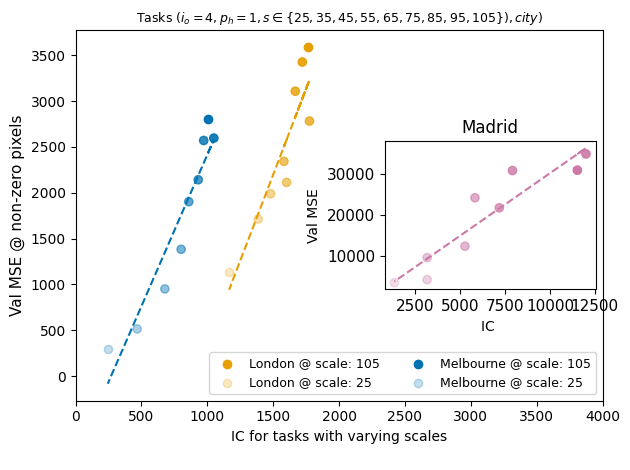

In [58]:
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# scales
for city in config.city_list:

    cityname = city.lower()
    line_plot_Val_loss = []

    city_label_printed = []

    val_loss_non_zero_list = []
    csr_model_list = []
    csr_PM_list = []
    csr_PM_frac_list = []
    
    for scale in config.scales[::-1]: #list(range(25, 206, 30))[::-1] + 
        for i_o_length in config.i_o_lengths_def:
            for pred_horiz in config.pred_horiz_def:
                prefix = ProcessRaw.file_prefix(cityname=cityname,
                                                io_length=i_o_length, 
                                                pred_horiz=pred_horiz, 
                                                scale=scale)
                filename = "val_csv_" + prefix + ".csv"
                try:
                    df = pd.read_csv(os.path.join("val_csv_all_models_all_cities", filename))
                except (pd.errors.EmptyDataError, FileNotFoundError) as e:
                    print (cityname, " Empty/Not found, ignoring; plot will be missing")
                    print (e)
                    continue
                    
                    
                epoch_list = df.epoch.tolist()
                val_loss = df.val_loss.tolist()
                naive_model= df["naive-model-non-zero"].tolist()
                val_non_zero_mse = df["val_non_zero_mse"].tolist()

                argmin = np.argmin(val_loss)

                min_val_mse_non_zero = val_non_zero_mse[argmin]

                alpha = 1
                facecolor = city_color[cityname]
                
                if naive_model[-1] < min_val_mse_non_zero:
                    # invalid, GIGO regime
                    print ("GIGO case: ", prefix)                    
                    
                    facecolor='none'
                    
                    # continue                    
                    

                    city_label_printed.append(cityname)
                line_plot_Val_loss.append(min_val_mse_non_zero)
                # plt.scatter(scale, naive_model[-1], marker='v', color=city_color[cityname])

    for CSR_type in [
    'CSR_PM_sum_y_exceeding_r_x_max',
        ]:

        cityname = city.lower()
        line_plot_IC = []


        city_label_printed = []      
        df = df_cx    

        # sprint (df.columns)
        for scale in config.scales[::-1]:
            for i_o_length in config.i_o_lengths_def:
                for pred_horiz in config.pred_horiz_def:

                    filtered_rows = df[    \
                                       (df["i_o_length"]==i_o_length) & \
                                       (df["grid_size"]==scale) & \
                                       (df["prediction_horizon"]==pred_horiz) &\
                                       (df["cityname"]==cityname)
                                      ]

                    
                    line_plot_IC.append(filtered_rows.iloc[0][CSR_type])
                            
    
    
    if cityname == "madrid":
        ax = plt.gca()  # Get the current axes
        axins = inset_axes(ax, width="40%", height="40%", loc='center right')
        axins.scatter(line_plot_IC, np.array(line_plot_Val_loss), color=city_color[cityname], 
                      alpha=np.array(config.scales[::-1])/105, label=cityname.title())

        p = np.polyfit(line_plot_IC, np.array(line_plot_Val_loss), 1)  # p will contain [slope, intercept]
        line_y = np.polyval(p, line_plot_IC)  # This evaluates the polynomial at each point in line_plot_IC
        axins.plot(line_plot_IC, line_y, color=city_color[cityname], linestyle='--')
        
        axins.set_title('madrid'.title())
        axins.set_xlabel("IC ")
        axins.set_ylabel('Val MSE')
        # axins.set_xticks(range(2000, 13000, 5000), fontsize=9)
    else:
        plt.scatter(line_plot_IC[1:-1], line_plot_Val_loss[1:-1], color=city_color[cityname], 
                    alpha=(np.array(config.scales[::-1])/105)[1:-1])
        plt.scatter(line_plot_IC[0], line_plot_Val_loss[0], color=city_color[cityname], 
                    alpha=np.array(config.scales[::-1][0])/105, label=cityname.title() + " @ scale: " + str(config.scales[::-1][0]))
        plt.scatter(line_plot_IC[-1], line_plot_Val_loss[-1], color=city_color[cityname], 
                    alpha=np.array(config.scales[::-1][-1])/105, label=cityname.title() + " @ scale: " + str(config.scales[::-1][-1]))        
        
        p = np.polyfit(line_plot_IC, np.array(line_plot_Val_loss), 1)  # p will contain [slope, intercept]
        line_y = np.polyval(p, line_plot_IC)  # This evaluates the polynomial at each point in line_plot_IC
        plt.plot(line_plot_IC, line_y, color=city_color[cityname], linestyle='--')
        
        plt.xlabel("IC for tasks with varying scales\n ", fontsize=10)
        plt.ylabel("Val MSE @ non-zero pixels", fontsize=11)
        plt.xlim(0, 4000)
        plt.legend(loc="lower right", ncol=2, fontsize=9) # loc="best", fontsize=8, ncol=3, labelspacing=0.02)
        plt.title(r"Tasks $(i_o=4, p_h=1, s\in\{25, 35, 45, 55, 65, 75, 85, 95, 105\}), city)$", fontsize=9)
# plt.yscale('symlog')
# plt.ylim(bottom=0.101)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

        
plt.tight_layout()
plt.savefig("Scales_csr_val_combo_scatter.png")
plt.show()

GIGO case:  melbourne-2-1-55-
GIGO case:  melbourne-1-1-55-
GIGO case:  madrid-8-1-55-
GIGO case:  madrid-7-1-55-
GIGO case:  madrid-1-1-55-


/var/folders/dp/q2rz500s2kj79pnbkf36h7ch0000gq/T/ipykernel_96000/3625037997.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


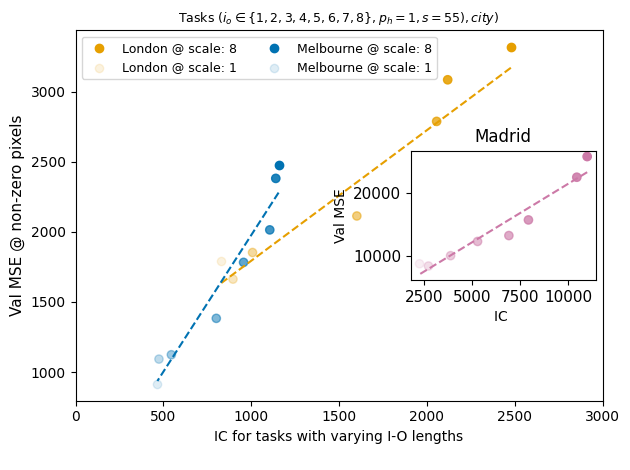

In [89]:
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# scales
for city in config.city_list:

    cityname = city.lower()
    line_plot_Val_loss = []

    city_label_printed = []

    val_loss_non_zero_list = []
    csr_model_list = []
    csr_PM_list = []
    csr_PM_frac_list = []
    
    for scale in config.scales_def: #list(range(25, 206, 30))[::-1] + 
        for i_o_length in config.i_o_lengths[::-1] :
            for pred_horiz in config.pred_horiz_def:
                prefix = ProcessRaw.file_prefix(cityname=cityname,
                                                io_length=i_o_length, 
                                                pred_horiz=pred_horiz, 
                                                scale=scale)
                filename = "val_csv_" + prefix + ".csv"
                try:
                    df = pd.read_csv(os.path.join("val_csv_all_models_all_cities", filename))
                except (pd.errors.EmptyDataError, FileNotFoundError) as e:
                    print (cityname, " Empty/Not found, ignoring; plot will be missing")
                    print (e)
                    continue
                    
                    
                epoch_list = df.epoch.tolist()
                val_loss = df.val_loss.tolist()
                naive_model= df["naive-model-non-zero"].tolist()
                val_non_zero_mse = df["val_non_zero_mse"].tolist()

                argmin = np.argmin(val_loss)

                min_val_mse_non_zero = val_non_zero_mse[argmin]

                alpha = 1
                facecolor = city_color[cityname]
                
                if naive_model[-1] < min_val_mse_non_zero:
                    # invalid, GIGO regime
                    print ("GIGO case: ", prefix)                    
                    
                    facecolor='none'
                    
                    # continue                    
                    

                    city_label_printed.append(cityname)
                line_plot_Val_loss.append(min_val_mse_non_zero)
                # plt.scatter(scale, naive_model[-1], marker='v', color=city_color[cityname])

    for CSR_type in [
    'CSR_PM_sum_y_exceeding_r_x_max',
        ]:

        cityname = city.lower()
        line_plot_IC = []


        city_label_printed = []      
        df = df_cx    

        # sprint (df.columns)
        for scale in config.scales_def:
            for i_o_length in config.i_o_lengths[::-1] :
                for pred_horiz in config.pred_horiz_def:

                    filtered_rows = df[    \
                                       (df["i_o_length"]==i_o_length) & \
                                       (df["grid_size"]==scale) & \
                                       (df["prediction_horizon"]==pred_horiz) &\
                                       (df["cityname"]==cityname)
                                      ]

                    
                    line_plot_IC.append(filtered_rows.iloc[0][CSR_type])
                            
    
    
    if cityname == "madrid":
        ax = plt.gca()  # Get the current axes
        axins = inset_axes(ax, width="35%", height="35%", loc='center right')
        axins.scatter(line_plot_IC, np.array(line_plot_Val_loss), color=city_color[cityname], 
                      alpha=np.array(config.i_o_lengths[::-1])/8, label=cityname.title())

        p = np.polyfit(line_plot_IC, np.array(line_plot_Val_loss), 1)  # p will contain [slope, intercept]
        line_y = np.polyval(p, line_plot_IC)  # This evaluates the polynomial at each point in line_plot_IC
        axins.plot(line_plot_IC, line_y, color=city_color[cityname], linestyle='--')
        
        axins.set_title('madrid'.title())
        axins.set_xlabel("IC ")
        axins.set_ylabel('Val MSE')
        # axins.set_xticks(range(2000, 13000, 5000), fontsize=9)
    else:
        plt.scatter(line_plot_IC[1:-1], line_plot_Val_loss[1:-1], color=city_color[cityname], 
                    alpha=(np.array(config.i_o_lengths[::-1])/8)[1:-1])
        plt.scatter(line_plot_IC[0], line_plot_Val_loss[0], color=city_color[cityname], 
                    alpha=np.array(config.i_o_lengths[::-1][0])/8, label=cityname.title() + " @ scale: " + str(config.i_o_lengths[::-1][0]))
        plt.scatter(line_plot_IC[-1], line_plot_Val_loss[-1], color=city_color[cityname], 
                    alpha=np.array(config.i_o_lengths[::-1][-1])/8, label=cityname.title() + " @ scale: " + str(config.i_o_lengths[::-1][-1]))        
        
        p = np.polyfit(line_plot_IC, np.array(line_plot_Val_loss), 1)  # p will contain [slope, intercept]
        line_y = np.polyval(p, line_plot_IC)  # This evaluates the polynomial at each point in line_plot_IC
        plt.plot(line_plot_IC, line_y, color=city_color[cityname], linestyle='--')
        
        plt.xlabel("IC for tasks with varying I-O lengths\n ", fontsize=10)
        plt.ylabel("Val MSE @ non-zero pixels", fontsize=11)
        plt.xlim(0, 3000)
        plt.legend(loc="best", ncol=2, fontsize=9) # loc="best", fontsize=8, ncol=3, labelspacing=0.02)
        plt.title(r"Tasks $(i_o\in\{1,2,3,4,5,6,7,8\}, p_h=1, s=55), city)$", fontsize=9)
# plt.yscale('symlog')
# plt.ylim(bottom=0.101)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

        
plt.tight_layout()
plt.savefig("IO_len_csr_val_combo_scatter.png")
plt.show()

/var/folders/dp/q2rz500s2kj79pnbkf36h7ch0000gq/T/ipykernel_96000/2725798965.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


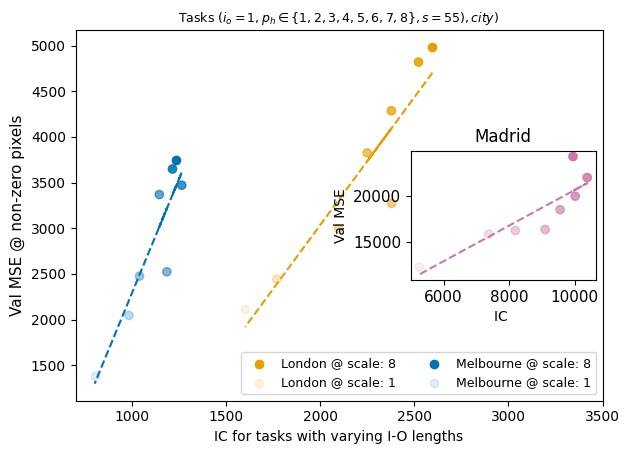

In [90]:
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# scales
for city in config.city_list:

    cityname = city.lower()
    line_plot_Val_loss = []

    city_label_printed = []

    val_loss_non_zero_list = []
    csr_model_list = []
    csr_PM_list = []
    csr_PM_frac_list = []
    
    for scale in config.scales_def: #list(range(25, 206, 30))[::-1] + 
        for i_o_length in config.i_o_lengths_def :
            for pred_horiz in config.pred_horiz[::-1]:
                prefix = ProcessRaw.file_prefix(cityname=cityname,
                                                io_length=i_o_length, 
                                                pred_horiz=pred_horiz, 
                                                scale=scale)
                filename = "val_csv_" + prefix + ".csv"
                try:
                    df = pd.read_csv(os.path.join("val_csv_all_models_all_cities", filename))
                except (pd.errors.EmptyDataError, FileNotFoundError) as e:
                    print (cityname, " Empty/Not found, ignoring; plot will be missing")
                    print (e)
                    continue
                    
                    
                epoch_list = df.epoch.tolist()
                val_loss = df.val_loss.tolist()
                naive_model= df["naive-model-non-zero"].tolist()
                val_non_zero_mse = df["val_non_zero_mse"].tolist()

                argmin = np.argmin(val_loss)

                min_val_mse_non_zero = val_non_zero_mse[argmin]

                alpha = 1
                facecolor = city_color[cityname]
                
                if naive_model[-1] < min_val_mse_non_zero:
                    # invalid, GIGO regime
                    print ("GIGO case: ", prefix)                    
                    
                    facecolor='none'
                    
                    # continue                    
                    

                    city_label_printed.append(cityname)
                line_plot_Val_loss.append(min_val_mse_non_zero)
                # plt.scatter(scale, naive_model[-1], marker='v', color=city_color[cityname])

    for CSR_type in [
    'CSR_PM_sum_y_exceeding_r_x_max',
        ]:

        cityname = city.lower()
        line_plot_IC = []


        city_label_printed = []      
        df = df_cx    

        # sprint (df.columns)
        for scale in config.scales_def:
            for i_o_length in config.i_o_lengths_def:
                for pred_horiz in config.pred_horiz[::-1]:

                    filtered_rows = df[    \
                                       (df["i_o_length"]==i_o_length) & \
                                       (df["grid_size"]==scale) & \
                                       (df["prediction_horizon"]==pred_horiz) &\
                                       (df["cityname"]==cityname)
                                      ]

                    
                    line_plot_IC.append(filtered_rows.iloc[0][CSR_type])
                            
    
    
    if cityname == "madrid":
        ax = plt.gca()  # Get the current axes
        axins = inset_axes(ax, width="35%", height="35%", loc='center right')
        axins.scatter(line_plot_IC, np.array(line_plot_Val_loss), color=city_color[cityname], 
                      alpha=np.array(config.pred_horiz[::-1])/8, label=cityname.title())

        p = np.polyfit(line_plot_IC, np.array(line_plot_Val_loss), 1)  # p will contain [slope, intercept]
        line_y = np.polyval(p, line_plot_IC)  # This evaluates the polynomial at each point in line_plot_IC
        axins.plot(line_plot_IC, line_y, color=city_color[cityname], linestyle='--')
        
        axins.set_title('madrid'.title())
        axins.set_xlabel("IC ")
        axins.set_ylabel('Val MSE')
        # axins.set_xticks(range(2000, 13000, 5000), fontsize=9)
    else:
        plt.scatter(line_plot_IC[1:-1], line_plot_Val_loss[1:-1], color=city_color[cityname], 
                    alpha=(np.array(config.pred_horiz[::-1])/8)[1:-1])
        plt.scatter(line_plot_IC[0], line_plot_Val_loss[0], color=city_color[cityname], 
                    alpha=np.array(config.pred_horiz[::-1][0])/8, label=cityname.title() + " @ scale: " + str(config.pred_horiz[::-1][0]))
        plt.scatter(line_plot_IC[-1], line_plot_Val_loss[-1], color=city_color[cityname], 
                    alpha=np.array(config.pred_horiz[::-1][-1])/8, label=cityname.title() + " @ scale: " + str(config.pred_horiz[::-1][-1]))        
        
        p = np.polyfit(line_plot_IC, np.array(line_plot_Val_loss), 1)  # p will contain [slope, intercept]
        line_y = np.polyval(p, line_plot_IC)  # This evaluates the polynomial at each point in line_plot_IC
        plt.plot(line_plot_IC, line_y, color=city_color[cityname], linestyle='--')
        
        plt.xlabel("IC for tasks with varying I-O lengths\n ", fontsize=10)
        plt.ylabel("Val MSE @ non-zero pixels", fontsize=11)
        plt.xlim(700, 3500)
        plt.legend(loc="best", ncol=2, fontsize=9) # loc="best", fontsize=8, ncol=3, labelspacing=0.02)
        plt.title(r"Tasks $(i_o=1, p_h\in\{1,2,3,4,5,6,7,8\}, s=55), city)$", fontsize=9)
# plt.yscale('symlog')
# plt.ylim(bottom=0.101)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

        
plt.tight_layout()
plt.savefig("Pred_horiz_val_combo_scatter.png")
plt.show()

In [79]:
line_plot_IC

[1601.3155,
 1769.38175,
 2097.79925,
 2379.7215,
 2249.153,
 2377.9935,
 2522.1485,
 2596.23175]

In [80]:
line_plot_Val_loss

[2113.390380859375]